In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


# The Sparse Vector Technique

```{admonition} Learning Objectives
After reading this chapter, you will be able to:
- Describe the Sparse Vector Technique and the reasons to use it
- Define and implement Above Threshold
- Apply the Sparse Vector Technique in iterative algorithms
```

We've already seen one example of a mechanism - the exponential mechanism - which achieves a lower-than-expected privacy cost by withholding some information. Are there others?

There are, and one that turns out to be extremely useful in practical algorithms is the *sparse vector technique* (SVT) {cite}`dwork2009A`. 

```{important}
The sparse vector technique operates on a stream of sensitivity-1 queries over a dataset; it releases the *identity* of the first query in the stream which passes a test, and nothing else.
```

The advantage of SVT is that it incurs a fixed total privacy cost, no matter *how many queries it considers*. 

## Above Threshold

The most basic instantiation of the sparse vector technique is an algorithm called `AboveThreshold` (see [Dwork and Roth](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf) {cite}`dwork2014`, Algorithm 1). The inputs to the algorithm are a stream of sensitivity-1 queries, a dataset $D$, a *threshold* $T$, and the privacy parameter $\epsilon$; the algorithm preserves $\epsilon$-differential privacy. A Python implementation of the algorithm appears below.

In [4]:
import random

# preserves epsilon-differential privacy
def above_threshold(queries, df, T, epsilon,on_fail="random"):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)   
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx
        
    # Handle failure case
    if on_fail == "random":
        # if the algorithm "fails", return a random index 
        # more convenient in certain use cases
        return random.randint(0, len(queries) - 1)
    else:
        return None
                                          

The `AboveThreshold` algorithm returns (approximately) the index of the first query in `queries` whose result exceeds the threshold. The algorithm preserves differential privacy by sometimes returning the *wrong* index; sometimes, the index returned may be for a query whose result does *not* exceed the threshold, and sometimes, the index may not be the *first* whose query result exceeds the threshold.

The algorithm works by generating a *noisy threshold* `T_hat`, then comparing noisy query answers (`q(i) + nu_i`) against the noisy threshold. The algorithm returns the index of the first comparison that succeeds.

It's a little bit surprising that the privacy cost of this algorithm is just $\epsilon$, because it may compute the answers to *many* queries. In particular, a naive version of this algorithm might compute noisy answers to all of the queries first, then select the index of the first one whose value is above the threshold:

In [5]:
# preserves |queries|*epsilon-differential privacy
def naive_above_threshold(queries, df, T, epsilon):
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 1/epsilon)
        if q(df) + nu_i >= T:
            return idx
    return None

For a list of queries of length $n$, this version preserves $n\epsilon$-differential privacy by sequential composition. 

Why does `AboveThreshold` do so much better? As we saw with the exponential mechanism, sequential composition would allow `AboveThreshold` to release *more information* than it actually does. In particular, our naive version of the algorithm could release the indices of *every* query exceeding the threshold (not just the first one), *plus* the noisy query answers themselves, and it would still preserve $n\epsilon$-differential privacy. The fact that `AboveThreshold` withholds all this information allows for a tighter analysis of privacy cost.

## Applying the Sparse Vector Technique

The sparse vector technique is extremely useful when we want to run many different queries, but we only care about the answer for one of them (or a small subset of them). In fact, this application gives the technique its name: it's most useful when the *vector* of queries is *sparse* - i.e. most of the answers don't exceed the threshold.

We've already seen a perfect example of such a scenario: selecting a clipping bound for summation queries. Earlier, we took an approach like the naive version of `AboveThreshold` defined above: compute noisy answers under many different clipping bounds, then select the lowest one for which the answer doesn't change much.

We can do much better with the sparse vector technique. Consider a query which clips the ages of everyone in the dataset, then sums them up:

In [6]:
def age_sum_query(df, b):
    return df['Age'].clip(lower=0, upper=b).sum()

age_sum_query(adult, 30)

np.int64(879648)

The naive algorithm for selecting a good value for `b` is to obtain differentially private answers for many values of `b`, returning the smallest one where the value stops increasing:

In [7]:
def naive_select_b(query, df, epsilon):
    bs = range(1, 1000, 10)
    best = 0
    threshold = 10
    epsilon_i = epsilon / len(bs)
    
    for b in bs:
        r = laplace_mech(query(df, b), b, epsilon_i)
        
        # if the new answer is pretty close to the old answer, stop
        if r - best <= threshold:
            return b
        # otherwise update the "best" answer to be the current one
        else:
            best = r
        
    return bs[-1]

naive_select_b(age_sum_query, adult, 1)

91

Can we use SVT here? We only care about one thing: the value of `b` where the value of `age_sum_query(df, b)` stops increasing. However, the sensitivity of `age_sum_query(df, b)` is `b`, because adding or removing a row in `df` could change the sum by at most `b`; to use SVT, we need to build a stream of 1-sensitive queries.

The value we actually care about, though, is whether or not the query's answer is *changing* at a specific value of $b$ (i.e. `age_sum_query(df, b) - age_sum_query(df, b + 1)`). Consider what happens when we add a row to `df`: the answer to the first part of the query `age_sum_query(df, b)` goes up by $b$, but the answer to the second part of the query `age_sum_query(df, b + 1)` *also* goes up - by $b + 1$. The sensitivity is therefore $\vert b - (b + 1) \vert = 1$ - so each query will be 1-sensitive, as desired! As the value of $b$ approaches the optimal one, the value of the difference we defined above will approach 0:

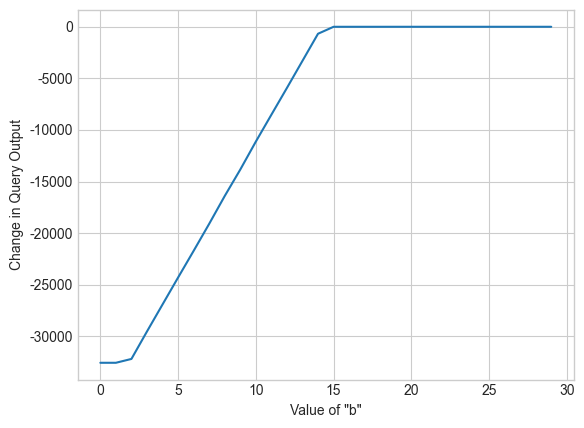

In [8]:
bs = range(1,150,5)
query_results = [age_sum_query(adult, b) - age_sum_query(adult, b + 1) for b in bs]
plt.xlabel('Value of "b"')
plt.ylabel('Change in Query Output')
plt.plot(query_results);

Let's define a stream of difference queries, and use `AboveThreshold` to determine the index of the best value of `b` using the sparse vector technique.

In [9]:
def create_query(b):
    return lambda df: age_sum_query(df, b) - age_sum_query(df, b + 1)

bs = range(1,150,5)
queries = [create_query(b) for b in bs]
epsilon = .1

bs[above_threshold(queries, adult, 0, epsilon)]

111

Note that it *doesn't matter* how long the list `bs` is - we'll get accurate results (and pay the same privacy cost) no matter its length. The really powerful effect of SVT is to eliminate the dependence of privacy cost on the number of queries we perform. Try changing the range for `bs` above and re-running the plot below. You'll see that the output doesn't depend on the number of values for `b` we try - even if the list has *thousands* of elements!

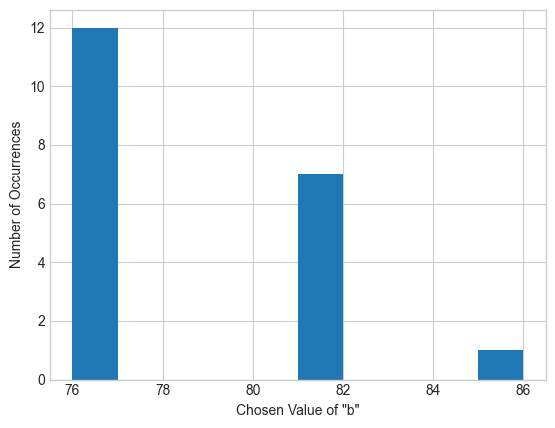

In [10]:
plt.xlabel('Chosen Value of "b"')
plt.ylabel('Number of Occurrences')
plt.hist([bs[above_threshold(queries, adult, 0, epsilon)] for i in range(20)]);

We can use SVT to build an algorithm for summation queries (and using this, for average queries) that automatically computes the clipping parameter.

In [11]:
def auto_avg(df, epsilon):
    def create_query(b):
        return lambda df: df.clip(lower=0, upper=b).sum() - df.clip(lower=0, upper=b+1).sum()

    # Construct the stream of queries
    bs = range(1,150000,5)
    queries = [create_query(b) for b in bs]
    
    # Run AboveThreshold, using 1/3 of the privacy budget, to find a good clipping parameter
    epsilon_svt = epsilon / 3
    final_b = bs[above_threshold(queries, df, 0, epsilon_svt)]

    # Compute the noisy sum and noisy count, using 1/3 of the privacy budget for each
    epsilon_sum = epsilon / 3
    epsilon_count = epsilon / 3
    
    noisy_sum = laplace_mech(df.clip(lower=0, upper=final_b).sum(), final_b, epsilon_sum)
    noisy_count = laplace_mech(len(df), 1, epsilon_count)
    
    return noisy_sum/noisy_count

auto_avg(adult['Age'], 1)

np.float64(41.76763109982805)

This algorithm invokes three differentially private mechanisms: `AboveThreshold` once, and the Laplace mechanism twice, each with $\frac{1}{3}$ of the privacy budget. By sequential composition, it satisfies $\epsilon$-differential privacy. Because we are free to test a really wide range of possible values for `b`, we're able to use the same `auto_avg` function for data on many different scales! For example, we can also use it on the capital gain column, even though it has a very different scale than the age column.

In [12]:
auto_avg(adult['Capital Gain'], 1)

np.float64(1090.459169221535)

Note that this takes a long time to run! That's because we have to try a lot more values for `b` before finding a good one, since the capital gain column has a much larger scale. We can reduce this cost by increasing the step size (5, in our implementation above) or by constructing `bs` with an exponential scale.

## Returning Multiple Values

In the above application, we only needed the index of the *first* query which exceeded the threshold, but in many other applications we would like to find the indices of *all* such queries.

We can use SVT to do this, but we'll have to pay a higher privacy cost. We can implement an algorithm called `sparse` (see [Dwork and Roth](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf) {cite}`dwork2014`, Algorithm 2) to accomplish the task, using a very simple approach:

1. Start with a stream $qs = \{q_1, \dots, q_k\}$ of queries
2. Run `AboveThreshold` on $qs$ to learn the index $i$ of the first query which exceeds the threshold
3. Restart the algorithm (go to (1)) with $qs = \{q_{i+1}, \dots, q_k\}$ (i.e. the *remaining* queries)

If the algorithm invokes `AboveThreshold` $k$ times, with a privacy parameter of $\epsilon$ for each invocation, then it satisfies $k\epsilon$-differential privacy by sequential composition. If we want to specify an upper bound on total privacy cost, we need to bound $k$ - so the `sparse` algorithm asks the analyst to specify an upper bound $c$ on the number of times `AboveThreshold` will be invoked.

In [13]:
def sparse(queries, df, c, T, epsilon):
    idxs = []
    pos = 0
    epsilon_i = epsilon / c
    
    # stop if we reach the end of the stream of queries, or if we find c queries above the threshold
    while pos < len(queries) and len(idxs) < c:
        # run AboveThreshold to find the next query above the threshold
        next_idx = above_threshold(queries[pos:], df, T, epsilon_i, on_fail=None)
        
        # if AboveThreshold reaches the end, return
        if next_idx == None:
            return idxs
        
        # otherwise, update pos to point to the rest of the queries
        pos = next_idx+pos
        # update return value to include the index found by AboveThreshold
        idxs.append(pos)
        # and move to the next query in the stream
        pos = pos + 1

    return idxs

In [14]:
epsilon = 1
sparse(queries, adult, 3, 0, epsilon)

[15, 16, 17]

By sequential composition, the `sparse` algorithm satisfies $\epsilon$-differential privacy (it uses $\epsilon_i = \frac{\epsilon}{c}$ for each invocation of `AboveThreshold`). The version described in Dwork and Roth uses advanced composition, setting the $\epsilon_i$ value for each invocation of `AboveThreshold` so that the total privacy cost is $\epsilon$ (zCDP or RDP could also be used to perform the composition).

## Application: Range Queries

A *range query* asks: "how many rows exist in the dataset whose values lie in the range $(a, b)$?" Range queries are counting queries, so they have sensitivity 1; we can't use parallel composition on a set of range queries, however, since the rows they examine might overlap.

Consider a set of range queries over ages (i.e. queries of the form "how many people have ages between $a$ and $b$?"). We can generate many such queries at random:

In [13]:
def age_range_query(df, lower, upper):
    df1 = df[df['Age'] > lower]
    return len(df1[df1['Age'] < upper])

def create_age_range_query():
    lower = np.random.randint(30, 50)
    upper = np.random.randint(lower, 70)
    return lambda df: age_range_query(df, lower, upper)


range_queries = [create_age_range_query() for i in range(10)]
results = [q(adult) for q in range_queries]
results

[16899, 16908, 11091, 8033, 11330, 4553, 18240, 8132, 9053, 11372]

The answers to such range queries vary widely - some ranges create tiny (or even empty) groups, with small counts, while others create large groups with high counts. In many cases, we know that the small groups will have inaccurate answers under differential privacy, so there's not much point in even running the query. What we'd like to do is learn which queries are worth answering, and then pay privacy cost for *just* those queries.

We can use the sparse vector technique to do this. First, we'll determine the indices of the range queries in the stream which exceed a threshold for "goodness" that we decide on. Then, we'll use the Laplace mechanism to find differentially private answers for *just* those queries. The total privacy cost will be proportional to the number of queries *above* the threshold - not the total number of queries. In cases where we expect just a few queries to be above the threshold, this can result in a much smaller privacy cost.

In [14]:
def range_query_svt(queries, df, c, T, epsilon):
    # first, run Sparse to get the indices of the "good" queries
    sparse_epsilon = epsilon / 2
    indices = sparse(queries, adult, c, T, sparse_epsilon)
    
    # then, run the Laplace mechanism on each "good" query
    laplace_epsilon = epsilon / (2*c)
    results = [laplace_mech(queries[i](df), 1, laplace_epsilon) for i in indices]
    return results

In [15]:
range_query_svt(range_queries, adult, 5, 10000, 1)

[16917.45574425689,
 16933.282003171324,
 11093.27636133087,
 11324.844036991903,
 18243.71176080326]

Using this algorithm, we pay half of the privacy budget to determine the first $c$ queries which lie above the threshold of 10000, then the other half of the budget to obtain noisy answers to *just* those queries. If the number of queries exceeding the threshold is tiny compared to the total number, then we're able to obtain much more accurate answers using this approach.

```{admonition} Glossary

- [Sparse Vector Technique — Wikipedia](https://en.wikipedia.org/wiki/Differential_privacy#Sparse_vector_technique)

```